In [1]:
import numpy as np
from spectral_clustering import spectral_clustering
import functions_for_plotting
from asymmetric_laplacian_distribution import get_index_per_class, get_labels, labels_to_layout_mapping
from sklearn.cluster import KMeans
import training_set_split
import seaborn as sns
import prediction_strength
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances

/Users/paule/anaconda3/envs/bon17/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#----------------------------------------------- DATA ------------------------------------------------------------------
data_dir = "data/"

clear_data = np.load(data_dir + "clearly_separated_data_F_signal_noise.npy")
ambig_data = np.load(data_dir + "ambiguous_data_tau_amplitude_F_signal_noise.npy")
#np.load(data_dir + "ambiguous_data_tau_amplitude_F_signal_noise.npy") #np.load(data_dir + "clearly_separated_data_F_signal_noise.npy")

clear_amplitude_conditions = ["S", "M", "L"]  #["S", "S/M", "M", "M/L", "L"] #["S", "M", "L"]
ambig_amplitude_conditions = ["S", "S/M", "M", "M/L", "L"]

clear_time_constant_conditions = ["equal_sharp", "equal_wide", "wide_sharp_negative_skew", "sharp_wide_positive_skew"]
ambig_time_constant_conditions = ["equal_sharp", "equal_medium", "equal_wide", "wide_sharp_negative_skew", "wide_medium_negative_skew","medium_sharp_negative_skew","sharp_wide_positive_skew", "medium_wide_positive_skew" ,"sharp_medium_positive_skew"]

#["equal_sharp", "equal_medium", "equal_wide", "wide_sharp_negative_skew", "wide_medium_negative_skew","medium_sharp_negative_skew","sharp_wide_positive_skew", "medium_wide_positive_skew" ,"sharp_medium_positive_skew"]
#["equal_sharp", "equal_wide", "wide_sharp_negative_skew", "sharp_wide_positive_skew"]

ambiguous_conditions = ["S/M", "M/L", "equal_medium", "wide_medium_negative_skew", "medium_sharp_negative_skew", "medium_wide_positive_skew", "sharp_medium_positive_skew"]

samples_per_condition = 1000
samples_per_ambiguous_condition = 400

ambig_cluster_dict = get_index_per_class(ambig_amplitude_conditions,ambig_time_constant_conditions, ambiguous_conditions, samples_per_condition, samples_per_ambiguous_condition)
clear_cluster_dict = get_index_per_class(clear_amplitude_conditions,clear_time_constant_conditions, [], samples_per_condition, samples_per_ambiguous_condition)


clear_true_labels = get_labels(clear_data, clear_cluster_dict)
ambig_true_labels = get_labels(ambig_data, ambig_cluster_dict)

clear_clusters_ordered = list(range(0,len(clear_cluster_dict)+1))
clear_layout_label_mapping = labels_to_layout_mapping(clear_clusters_ordered, 4, (1,4)) #labels_to_layout_mapping(clusters_ordered, 4, (1,4)) #labels_to_layout_mapping(clusters_ordered, 9, (2,5))

ambig_clusters_ordered = list(range(0,len(ambig_cluster_dict)+1))
ambig_layout_label_mapping = labels_to_layout_mapping(ambig_clusters_ordered, 9, (2,5))

In [3]:
data = clear_data
cluster_dict = clear_cluster_dict

In [4]:
test_data = np.zeros((len(cluster_dict.keys())*100, len(data[0])))
test_cluster_dict = {}
for i,key in enumerate(list(cluster_dict.keys())):
    start = cluster_dict[key][0]
    test_data[i*100:(i+1)*100,:] = data[start:start+100,:]
    test_cluster_dict[key] = (i*100,(i+1)*100-1)

In [6]:
test_data.shape

(1200, 3501)

# Sparse Subspace Coefficients

- Self expressiveness of the data
- each datapoint as linear combination of the others
- similarity graph based on coefficient representation

In [7]:
!pip install cvxpy

     |████████████████████████████████| 746 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 158 kB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 151 kB 3.8 MB/s eta 0:00:01
  Created wheel for multiprocess: filename=multiprocess-0.70.9-py3-none-any.whl size=108029 sha256=c06e69b9eff06e78ab90f2838cca5f76c0a74ff9b1d4700bf87894dc6ebcb697
  Stored in directory: /Users/paule/Library/Caches/pip/wheels/83/2b/b4/50d7cae5b9069434454fd36da009832592af4fff58b51db8d9
  Created wheel for scs: filename=scs-2.1.2-cp37-cp37m-macosx_10_9_x86_64.whl size=124434 sha256=5db1e35fe74b253a135adc3f6e0a0019cb61c4db7f630c70aa2e9b99350383ef
  Stored in directory: /Users/paule/Library/Caches/pip/wheels/bc/e9/2d/41c52bfaefbbbee5b3c6c189e168039f6ac9b40fa2e14fe96d
  Created wheel for ec

In [8]:
import cvxpy as cp

y_i = test_data[0]
print(y_i.shape)
print(test_data.shape)

(3501,)
(1200, 3501)


In [15]:
c = cp.Variable(test_data.shape[0]-1)
X_i = np.delete(test_data, 0, axis = 0)

In [16]:
print(c.shape)
print(X_i.shape)

(1199,)
(1199, 3501)


In [21]:
prob = cp.Problem(cp.Minimize(cp.sum(cp.abs(c)) + 0.1* cp.sum_squares(y_i - c @ X_i )))
optimal_value = prob.solve()
print("c=",c.value)
print("val=",optimal_value)

c= [ 1.57913636e-15 -2.97116831e-16 -1.42219088e-14 ...  1.00532088e-11
  8.11509568e-12  7.12092074e-13]
val= 0.09643227629915738


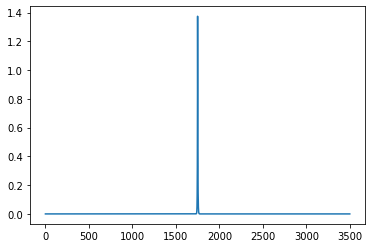

In [27]:
plt.plot(y_i)

In [31]:
c.value @ X_i

array([ 1.47047923e-03,  2.25519434e-03,  5.47152007e-03, ...,
        3.23411069e-03, -6.79386345e-05,  4.53919139e-03])

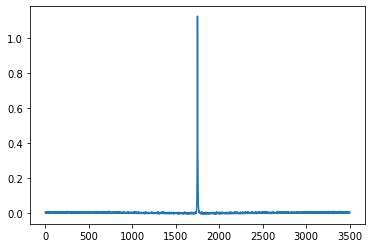

In [32]:
plt.plot(c.value @ X_i)

In [9]:
C = np.zeros((test_data.shape[0], test_data.shape[0] - 1))
for i,burst in enumerate(test_data):
    if i % 100 == 0:
        print("Solving for: %d-th burst!" % i)
    c = cp.Variable(test_data.shape[0]-1)
    X_i = np.delete(test_data, i, axis = 0)
    prob = cp.Problem(cp.Minimize(cp.sum(cp.abs(c)) + 0.1* cp.sum_squares(burst - c @ X_i )))
    optimal_value = prob.solve()
    #print("c=",c.value)
    #print("val=",optimal_value)
    C[i] = c.value

Solving for: 0-th burst!
Solving for: 100-th burst!
Solving for: 200-th burst!
Solving for: 300-th burst!
Solving for: 400-th burst!
Solving for: 500-th burst!
Solving for: 600-th burst!
Solving for: 700-th burst!
Solving for: 800-th burst!
Solving for: 900-th burst!
Solving for: 1000-th burst!
Solving for: 1100-th burst!


In [10]:
#np.save("sparse_coefficents", C)

In [11]:
A = C.copy()

In [16]:
A.shape

(1200, 1199)

In [12]:
A_new = np.zeros((len(test_data), len(test_data)))

for i in range(len(test_data)):
    mask = np.ones(len(test_data),dtype=bool)
    mask[i] = False
    A_new[i,mask] = A[i] 

In [13]:
W = np.absolute(A_new) + np.absolute(A_new.T)

In [31]:
labels_valid, eigvec_valid, eigval_valid = spectral_clustering(test_data, "precomputed", "similarity" ,range(1,50), k=4, precomputed_matrix=W, mutual = False, weighting = True, normalize = True, reg_lambda = None, save_laplacian = False, save_eigenvalues_and_vectors = False)

Use precomputed matrix for constructing KNN-Graph
Build symmetric KNN-Graph based on Similarity of data points!
Weighting: True
Calculate Normalized Laplacians
Normalization: symmetric
Calculate Eigenvalues and Vectors of Laplacian


In [26]:
labels_valid, eigvec_valid, eigval_valid = spectral_clustering(test_data, "euclidean", "distance" ,range(1,50), k=10, precomputed_matrix=None, mutual = False, weighting = False, normalize = True, reg_lambda = None, save_laplacian = False, save_eigenvalues_and_vectors = False)

Calculate euclidean matrix for constructing KNN-Graph
Build symmetric KNN-Graph based on Distance of data points!
Weighting: False
Calculate Normalized Laplacians
Normalization: symmetric
Calculate Eigenvalues and Vectors of Laplacian


In [30]:
labels_valid[11][0:100]

array([ 2,  2, 10, 10,  2, 11,  2, 10, 10,  2,  2, 10,  2, 11,  2,  6, 10,
        2,  2,  6, 11,  2, 11, 11, 10, 11,  2,  2, 10,  6, 10, 11,  2, 10,
       11,  6, 11, 11, 10, 11, 11,  2, 11, 10, 11, 11,  2,  2, 11, 11, 11,
       10, 10, 10, 11,  2, 11,  2,  2,  2, 10, 10, 11,  6, 11, 11,  6,  2,
        2, 10,  2, 11, 10, 10,  2,  2, 10, 10,  6,  6,  2,  2, 11, 11,  2,
        2,  2,  6,  6, 10, 10,  6, 10, 11, 10, 11,  6, 10, 10, 10],
      dtype=int32)

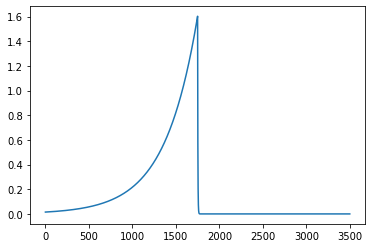

In [89]:
plt.plot(test_data[20])

In [83]:
A_new[-1].shape

(120,)

In [84]:
test_data[-1].shape

(3501,)

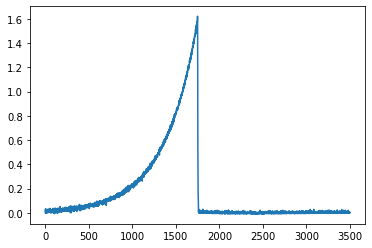

In [90]:
plt.plot(A_new[20] @ test_data)

In [32]:
test_clustered_labels = {}
for i, labels in enumerate(labels_valid):
    test_clustered_labels[i+1] = labels    

In [37]:
test_true_labels = get_labels(test_data, test_cluster_dict)

test_clusters_ordered = list(range(0,len(test_cluster_dict)+1))
test_layout_label_mapping = labels_to_layout_mapping(test_clusters_ordered, 4, (1,4)) #labels_to_layout_mapping(clusters_ordered, 4, (1,4)) #labels_to_layout_mapping(clusters_ordered, 9, (2,5))


save_file_clusters = "subset_sparse_subspace_clustering_k=4_reg=None.pdf"

functions_for_plotting.plot_clusters(test_data, # the dataset 
                                     test_true_labels, # the true labels for the dataset 
                                     test_clustered_labels[12],  # the clustered labels 
                                     3, # the number of rows in the grid 
                                     4, # the number of columns in the grid 
                                     clear_layout_label_mapping, # our layout mapping
                                     figsize=(20,20), # the figsize
                                     n_bursts = 100, # the number of bursts you want to plot for each cluster 
                                     y_lim = (0,16), # the y_lim
                                     save_file=save_file_clusters, # the file you want to save the plot 
                                     subplot_adjustments= [0.05,0.95,0.03,0.9,0.4, 0.15], # adjustments for suplots and overall spacing (tricky) 
                                     plot_mean=False, # plot the mean of each cluster ? 
                                     title= "Sparse Subspace Clusters \n k=4 reg=None" ) # title of the plot


/Users/paule/Desktop/Burst_Clustering/functions_for_plotting.py:271: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(outer_grid[row_i:(row_i + 1), column_i])
/Users/paule/Desktop/Burst_Clustering/functions_for_plotting.py:277: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(outer_grid[row_start:row_end, corresponding_column])
/Users/paule/Desktop/Burst_Clustering/functions_for_plotting.py:27